# GD6. 임베딩 내 편향성 알아보기

## 워드 임베딩의 편향성
* <Man is to Computer Programmer as Woman is to Homemaker? Debiasing Word Embeddings> https://arxiv.org/pdf/1607.06520.pdf
    - 젠더 중립적이어야 할 단어들이 특정 성별대명사와 가깝게 나타남 (Programmer, Doctor, Engineer 등의 단어는 남성대명사 He에 가깝게, Homemaker, Nurse, Hairdresser 등의 단어는 여성대명사 She에 가깝게)
    - 워드 임베딩 속 벡터들에는 어쩌면 우리가 가지고 있을지도 모를 편견이 고스란히 반영되어 있었다는 걸 보여주는 사례
* WEAT (Word Embedding Association Test)
    - 임베딩 모델의 편향을 측정하는 방식 중 하나
    - 2016년 Aylin Caliskan이 제안: https://arxiv.org/pdf/1608.07187.pdf
    - Science와 Art *(target)*, Male과 Female *(attribute)* 이라는 개념을 가장 잘 대표하는 단어들을 여러 개 골라 단어 셋을 만들고, 셋에 속한 단어끼리의 편향성을 전부 계산해 평균수치화
    - 두 개의 개념축을 설정: Science를 대표하는 target 단어셋 X와 Art를 대표하는 target 단어셋 Y 를 통한 X-Y 개념축 하나와, Male을 대표하는 attribute 단어셋 A와 Female을 대표하는 attribute 단어셋 B를 통한 A-B 개념축 하나
    - https://developers.googleblog.com/2018/04/text-embedding-models-contain-bias.html
        - 표에서 파란색은 사람의 편향과 같은 경우, 노란색은 사람의 편향과 다른 경우를 나타내는데, 대부분 사람의 편향과 같다. 즉 사람의 편향이 자연어 코퍼스에 반영되어 있고, 그 데이터로 만든 워드 임베딩 모델은 편향을 내재할 수밖에 없다는 뜻

## WEAT를 사용한 편향성 측정
- WEAT score: $\frac{mean_{x \in X}s(x, A, B) - mean_{y \in Y}s(y, A, B)}{std_{w \in X \cup Y}s(w, A, B)}$
    - 분자: target X, Y에 속하는 각 단어 x, y들이 개념축 A-B에 대해 가지는 편향성을 다시 평균내서 뺀 차이
    > "즉, X에 속하는 단어들과 Y에 속하는 단어들이 A-B 개념축에 대해 가지는 편향성의 정도가 뚜렷이 차이날 수록 이 WEAT score 식의 분자값의 절대값은 커지게 됩니다."
    - 위 분자를, X, Y에 속하는 모든 단어들이 가지는 편향성 값의 표준편차로 normalize하면 WEAT score가 되는 것
    - cosine similarity 이용: 두 벡터 사이의 코사인 값을 이용해 벡터의 유사도를 측정하며, -1과 1 사이의 값을 가진다. 두 벡터의 방향이 얼마나 유사한지를 나타낸다 (코사인 유사도는 두 벡터 i, j가 주어졌을 때 dot product의 magnitude를 사용해 구함. $cos(\theta) = \frac{i \cdot j}{||i|| ||j||}$)
        - $cos(\theta) = 1$: 두 벡터의 방향이 똑같을 때
        - $cos(\theta) = 0$: 두 벡터가 직교할 때
        - $cos(\theta) = -1$: 두 벡터의 방향이 반대일 때
        - (참고) 코사인 유사도 https://wikidocs.net/24603 $similarity=cos(Θ)=\frac{A⋅B}{||A||\ ||B||}=\frac{\sum_{i=1}^{n}{A_{i}×B_{i}}}{\sqrt{\sum_{i=1}^{n}(A_{i})^2}×\sqrt{\sum_{i=1}^{n}(B_{i})^2}}$
    - $s(w, A, B)$: 개별 단어 w가 개념축 A-B에 대해 가지는 편향성을 계산한 값. -2에서 2 사이의 값을 가지게 되며, 그 절대값이 클수록 w가 A-B 개념축에 대해 편향성을 가진다는 뜻. $s(w, A, B) = {\rm{mean}_{\it a \in A}cos(\it\overrightarrow{w}, \overrightarrow{a}) - \rm{mean}_{\it b \in B}{cos(\it\overrightarrow{w}, \overrightarrow{b})}}$

## WEAT 구현하기
* 2개의 target 단어 셋 X, Y (두 셋의 크기는 같아야 함) 와,
* 2개의 attribute 단어 셋 A, B (두 셋의 크기는 같아야 함) 를 정의
* 아래 코드는 다음과 같은 target, attribute 단어 셋들의 임베딩 결과
    - targets
        - A set(꽃) : 장미, 튤립, 백합, 데이지
        - B set(곤충) : 거미, 모기, 파리, 메뚜기
    - attributes
        - X set(유쾌) : 사랑, 행복, 웃음
        - Y set(불쾌) : 재난, 고통, 증오

In [1]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import os
from gensim.models import KeyedVectors

from konlpy.tag import Okt
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
# 단어들의 임베딩 결과

target_A = {
    '장미': [4.1, 1.2, -2.4, 0.5, 4.1],
    '튤립': [3.1, 0.5, 3.6, 1.7, 5.8],
    '백합': [2.9, -1.3, 0.4, 1.1, 3.7],
    '데이지': [5.4, 2.5, 4.6, -1.0, 3.6]
}
target_B = {
    '거미': [-1.5, 0.2, -0.6, -4.6, -5.3],
    '모기': [0.4, 0.7, -1.9, -4.5, -2.9],
    '파리': [0.9, 1.4, -2.3, -3.9, -4.7],
    '메뚜기': [0.7, 0.9, -0.4, -4.1, -3.9]
}
attribute_X = {
    '사랑':[2.8,  4.2, 4.3,  0.3, 5.0],
    '행복':[3.8,  3. , -1.2,  4.4, 4.9],
    '웃음':[3.7, -0.3,  1.2, -2.5, 3.9]
}
attribute_Y = {
    '재난': [-0.2, -2.8, -4.7, -4.3, -4.7],
    '고통': [-4.5, -2.1,  -3.8, -3.6, -3.1],
    '증오': [-3.6, -3.3, -3.5,  -3.7, -4.4]
}

In [3]:
A = np.array([v for v in target_A.values()])
B = np.array([v for v in target_B.values()])
print(A)
print(B)

[[ 4.1  1.2 -2.4  0.5  4.1]
 [ 3.1  0.5  3.6  1.7  5.8]
 [ 2.9 -1.3  0.4  1.1  3.7]
 [ 5.4  2.5  4.6 -1.   3.6]]
[[-1.5  0.2 -0.6 -4.6 -5.3]
 [ 0.4  0.7 -1.9 -4.5 -2.9]
 [ 0.9  1.4 -2.3 -3.9 -4.7]
 [ 0.7  0.9 -0.4 -4.1 -3.9]]


In [4]:
X = np.array([v for v in attribute_X.values()])
Y = np.array([v for v in attribute_Y.values()])
print(X)
print(Y)

[[ 2.8  4.2  4.3  0.3  5. ]
 [ 3.8  3.  -1.2  4.4  4.9]
 [ 3.7 -0.3  1.2 -2.5  3.9]]
[[-0.2 -2.8 -4.7 -4.3 -4.7]
 [-4.5 -2.1 -3.8 -3.6 -3.1]
 [-3.6 -3.3 -3.5 -3.7 -4.4]]


In [5]:
# s('사랑', A, B) 를 계산해보면,

def cos_sim(i, j): # cosine similarity
    return dot(i, j.T)/(norm(i)*norm(j)) # https://wikidocs.net/24603

def s(w, A, B): # w라는 단어의 A-B 개념축에서의 편향성
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b

print(s(attribute_X['사랑'], A, B)) # WEAT score 값이 양수이므로,
# attribute_X에 있는 '사랑'이라는 단어는 target_B(곤충) 보다 target_A(꽃)와 더 가깝다

0.5901751654626237


In [6]:
# s('재난', A, B) 도 계산해보면,
print(s(attribute_Y['재난'], A, B)) # WEAT score 값이 음수이므로,
# '재난'은 target_B와 더 가깝다

-0.6691842929755343


In [7]:
# attribute_X 와 target_A, target_B 사이의 평균값과,
# attribute_Y 와 target_A, target_B 사이의 평균값은?

print(s(X, A, B))
print(round(np.mean(s(X, A, B)), 3), '\n')

print(s(Y, A, B))
print(round(np.mean(s(Y, A, B)), 3))

[0.37181942 0.41632807 0.21117431]
0.333 

[-0.39609272 -0.37389852 -0.41242037]
-0.394


In [8]:
# WEAT score 수식을 코드로 나타내보면,

def weat_score(X, Y, A, B): 
    # 1. A-B 개념축에 대한 X, Y의 각 편향성을 구한 후
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)
    
    # 2. 각 편향성을 평균내,
    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    # 3. 편향성을 병합한 (concatenated) 표준편차로 나눈다
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return (mean_X-mean_Y) / std_dev

print(round(weat_score(X, Y, A, B), 3)) # WEAT score가 매우 높음
# 즉, 꽃은 유쾌한 단어와 상대적으로 가깝고, 곤충은 불쾌한 단어와 가깝다

1.97


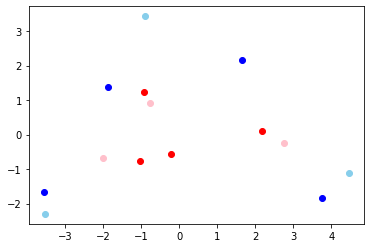

In [9]:
# PCA를 통해 5차원을 2차원으로 줄여서, 시각적으로 확인
# 참고: PCA https://medium.com/@john_analyst/pca-%EC%B0%A8%EC%9B%90-%EC%B6%95%EC%86%8C-%EB%9E%80-3339aed5afa1

pca = PCA(n_components=2)
pc_A = pca.fit_transform(A)
pc_B = pca.fit_transform(B)
pc_X = pca.fit_transform(X)
pc_Y = pca.fit_transform(Y)

# 파란색 점(A)과 하늘색 점(X)이 가깝고, 빨간색 점(B)과 분홍색 점(Y)이 가깝게 표현된 것을 확인할 수 있다
fig, ax = plt.subplots()
ax.scatter(pc_A[:,0],pc_A[:,1], c='blue', label='A')
ax.scatter(pc_B[:,0],pc_B[:,1], c='red', label='B')
ax.scatter(pc_X[:,0],pc_X[:,1], c='skyblue', label='X')
ax.scatter(pc_Y[:,0],pc_Y[:,1], c='pink', label='Y')

## 사전학습된 Word Embedding에 WEAT 적용

In [10]:
data_dir = 'weat/' 
model_dir = os.path.join(data_dir, 'GoogleNews-vectors-negative300.bin')

w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True)
w2v

In [11]:
print(len(w2v.vocab)) # 총 단어 수 300만개
print(len(w2v['I'])) # 각 단어는 300차원
print(w2v.vectors.shape)

3000000
300
(3000000, 300)


In [12]:
w2v['happy'] # 'happy'라는 단어 살펴보기

array([-5.18798828e-04,  1.60156250e-01,  1.60980225e-03,  2.53906250e-02,
        9.91210938e-02, -8.59375000e-02,  3.24218750e-01, -2.17285156e-02,
        1.34765625e-01,  1.10351562e-01, -1.04980469e-01, -2.90527344e-02,
       -2.38037109e-02, -4.02832031e-02, -3.68652344e-02,  2.32421875e-01,
        3.20312500e-01,  1.01074219e-01,  5.83496094e-02, -2.91824341e-04,
       -3.29589844e-02,  2.11914062e-01,  4.32128906e-02, -8.59375000e-02,
        2.81250000e-01, -1.78222656e-02,  3.79943848e-03, -1.71875000e-01,
        2.06054688e-01, -1.85546875e-01,  3.73535156e-02, -1.21459961e-02,
        2.04101562e-01, -3.80859375e-02,  3.61328125e-02, -8.15429688e-02,
        8.44726562e-02,  9.37500000e-02,  1.44531250e-01,  7.42187500e-02,
        2.51953125e-01, -7.91015625e-02,  8.69140625e-02,  1.58691406e-02,
        1.09375000e-01, -2.23632812e-01, -5.15747070e-03,  1.68945312e-01,
       -1.36718750e-01, -2.51464844e-02, -3.85742188e-02, -1.33056641e-02,
        1.38671875e-01,  

In [13]:
w2v.most_similar(positive=['happy']) # 'happy'와 가장 유사한 단어 보기

# limit: 메모리 사용량 줄이기 (자주 쓰는 n개의 단어만 사용하도록 설정)
# w2v = KeyedVectors.load_word2vec_format(model_dir, binary=True, limit=500000)

[('glad', 0.7408890724182129),
 ('pleased', 0.6632170677185059),
 ('ecstatic', 0.6626912355422974),
 ('overjoyed', 0.6599286794662476),
 ('thrilled', 0.6514049768447876),
 ('satisfied', 0.6437948942184448),
 ('proud', 0.636042058467865),
 ('delighted', 0.6272379159927368),
 ('disappointed', 0.6269949674606323),
 ('excited', 0.6247665882110596)]

* 논문에 있던 단어 셋으로 모델의 편향성 확인 http://www.cs.bath.ac.uk/~jjb/ftp/CaliskanSemantics-Arxiv.pdf

In [14]:
target_A = ['science', 'technology', 'physics', 'chemistry', 'Einstein', 'NASA', 'experiment', 'astronomy']
target_B = ['poetry', 'art', 'Shakespeare', 'dance', 'literature', 'novel', 'symphony', 'drama']
attribute_X = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_Y = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

A = np.array([w2v[word] for word in target_A])
B = np.array([w2v[word] for word in target_B])
X = np.array([w2v[word] for word in attribute_X])
Y = np.array([w2v[word] for word in attribute_Y])

weat_score(X, Y, A, B) # 과학과 관련된 단어는 남성을, 예술과 관련된 단어는 여성을 지칭하는 단어와 가까움

1.4821917

* 다른 단어 셋 구성
    - target_A: 인스턴트 식품 / target_B: 그 반대
    - attribute_X: 인스턴트를 의미하는 단어 / attributes_Y: 그 반대
* 보통 A는 X와, B는 Y와 가깝다고 생각할 것이고, 모델도 마찬가지 결과를 도출

In [15]:
target_A = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_B = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_X = ['junk', 'canned', 'convenience', 'frozen', 'fast']
attribute_Y = ['health', 'beneficial', 'good', 'nourishing', 'nutritious']

A = np.array([w2v[word] for word in target_A])
B = np.array([w2v[word] for word in target_B])
X = np.array([w2v[word] for word in attribute_X])
Y = np.array([w2v[word] for word in attribute_Y])

weat_score(X, Y, A, B)

1.6929383

* 또 다른 단어 셋 구성
    - attribute_X: 책과 관련된 단어 / attribute_Y: 뉴스와 관련된 단어
* 0에 가까운 값: 임베딩 모델이 판단하기에 어느 것끼리 가깝다고 말할 수 없는 것

In [16]:
target_A = ['pizza', 'coke', 'hamburger', 'ham', 'ramen', 'icecream', 'candy']
target_B = ['salad', 'fruit', 'vegetable', 'herb', 'root', 'greens', 'wholesome']
attribute_X = ['book', 'essay', 'dictionary', 'magazine', 'novel']
attribute_Y = ['news', 'report', 'statement', 'broadcast', 'word']

A = np.array([w2v[word] for word in target_A])
B = np.array([w2v[word] for word in target_B])
X = np.array([w2v[word] for word in attribute_X])
Y = np.array([w2v[word] for word in attribute_Y])

weat_score(X, Y, A, B)

-0.082050726

* 직접 단어 셋 구성해보기
    - target_A: 기계, 전자 / target_B: 손으로 쓰는 필기도구
    - attribute_X: 남성 / attribute_Y: 여성
* 결과 -0.5592858 (매우 0에 가까운 값): 어느 것끼리 가깝다고 판단할 수 없다

In [17]:
target_A = ['notebook', 'laptop', 'smartphone', 'car', 'CPU', 'computer']
target_B = ['pencil', 'note', 'eraser', 'pen', 'book']
attribute_X = ['brother', 'father', 'uncle', 'grandfather', 'son', 'he', 'his', 'him']
attribute_Y = ['sister', 'mother', 'aunt', 'grandmother', 'daughter', 'she', 'hers', 'her']

A = np.array([w2v[word] for word in target_A])
B = np.array([w2v[word] for word in target_B])
X = np.array([w2v[word] for word in attribute_X])
Y = np.array([w2v[word] for word in attribute_Y])

weat_score(X, Y, A, B)

-0.5592858

## 직접 만드는 Word Embedding에 WEAT 적용 (1)
1. 형태소 분석기를 이용하여 품사가 명사인 경우, 해당 단어를 추출하기
2. 추출된 결과로 embedding model 만들기
3. TF/IDF로 해당 데이터를 가장 잘 표한하는 단어 셋 만들기
4. embedding model과 단어 셋으로 WEAT score 구해보기

### 형태소 분석기를 이용해 품사가 명사인 경우 해당 단어를 추출하기

In [18]:
with open('weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [19]:
# 약 10분 정도 걸립니다.

okt = Okt()
tokenized = []

with open('weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [20]:
print(len(tokenized))

71156


### 추출된 결과로 embedding model 만들기

In [21]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. 
w2v = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  

w2v.most_similar(positive=['영화'])

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  after removing the cwd from sys.path.


[('작품', 0.9050722718238831),
 ('드라마', 0.854395866394043),
 ('다큐멘터리', 0.8513395190238953),
 ('영화로', 0.823225200176239),
 ('주제', 0.8071016073226929),
 ('코미디', 0.8039590120315552),
 ('에마데딘', 0.8034116625785828),
 ('형식', 0.797991156578064),
 ('가족영화', 0.7845638394355774),
 ('스토리', 0.7841569781303406)]

In [22]:
w2v.most_similar(positive=['사랑'])

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('아르튬', 0.7701172232627869),
 ('애정', 0.7316813468933105),
 ('행복', 0.7162643671035767),
 ('토마슈', 0.7125635147094727),
 ('세츠코', 0.7120689153671265),
 ('첫사랑', 0.7110218405723572),
 ('만남', 0.7108822464942932),
 ('정일', 0.709182858467102),
 ('이별', 0.7077003717422485),
 ('연애', 0.7049698233604431)]

In [23]:
w2v.most_similar(positive=['연극'])

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('시나리오', 0.9095653295516968),
 ('캐스팅', 0.8998174667358398),
 ('배우', 0.8987956047058105),
 ('영화감독', 0.8971552848815918),
 ('각색', 0.8871586322784424),
 ('공연', 0.8855307102203369),
 ('팬', 0.8798086643218994),
 ('뮤지션', 0.8751577734947205),
 ('오페라', 0.8745507001876831),
 ('데뷔', 0.8744887709617615)]

## 직접 만드는 Word Embedding에 WEAT 적용 (2)
### TF-IDF로 해당 데이터를 가장 잘 표현하는 단어셋 만들기
* 두 축을 어떤 기준으로 잡고, 해당 축의 어떤 항목을 사용할지 정해야 함
     - 영화 구분 *(영화 구분 정보란 일반영화, 예술영화, 독립영화로 구분된 정보입니다. KOBIS에서 제공한 정보를 기준으로 분류하였습니다.)*
        - synopsis_art.txt : 예술영화
        - synopsis_gen.txt : 일반영화(상업영화)
        - 그 외 독립영화 등으로 분류됩니다.
     - 장르
        - synopsis_SF.txt: SF
        - synopsis_가족.txt: 가족
        - synopsis_공연.txt: 공연
        - synopsis_공포(호러).txt: 공포(호러)
        - synopsis_기타.txt: 기타
        - synopsis_다큐멘터리.txt: 다큐멘터리
        - synopsis_드라마.txt: 드라마
        - synopsis_멜로로맨스.txt: 멜로로맨스
        - synopsis_뮤지컬.txt: 뮤지컬
        - synopsis_미스터리.txt: 미스터리
        - synopsis_범죄.txt: 범죄
        - synopsis_사극.txt: 사극
        - synopsis_서부극(웨스턴).txt: 서부극(웨스턴)
        - synopsis_성인물(에로).txt: 성인물(에로)
        - synopsis_스릴러.txt: 스릴러
        - synopsis_애니메이션.txt: 애니메이션
        - synopsis_액션.txt: 액션
        - synopsis_어드벤처.txt: 어드벤처
        - synopsis_전쟁.txt: 전쟁
        - synopsis_코미디.txt: 코미디
        - synopsis_판타지.txt: 판타지
* 예술영화/일반영화(상업영화) 구분을 target으로, 드라마/액션 장르를 attribute로 삼아 WEAT score 계산
    - 드라마장르에는 예술영화적 성격이 강하고, 액션장르에는 일반(상업)영화적 성격이 강할 것이라는 편향성이 워드 임베딩 상에 얼마나 나타나고 있는지를 측정

In [24]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open('weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [25]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


* 총 4개의 단어 셋 (X, Y, A, B) 생성
    - 예술영화라는 개념을 가장 잘 대표하는 단어들을 ```art_txt```를 처리해서 만든 ```art```에서 골라내는 식
    - 단어 선정에 정해진 방법이 있는 건 아니지만, 이번 경우 예술영화 시놉시스에는 자주 나타나지만 그 외 다른 구분의 영화(예를 들어 일반영화) 시놉시스에는 자주 나타나지 않는 것을 고르는 것이 적당할 것
    - TF-IDF 사용: 코퍼스에서 자주 나타나는(TF가 높은) 단어이지만, 다른 코퍼스에까지 두루 걸쳐 나오지는 않는(IDF가 높은) 단어를 선정
    - TF-IDF: https://wikidocs.net/31698

In [26]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [27]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [28]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 spart matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 spart matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

* 양쪽에 중복되는 단어가 너무 많은 상황
* 상위 100개의 단어 중 중복되는 단어 제외하고 상위 n(=15)개의 단어 추출

In [29]:
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in w2v.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in w2v.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [30]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [31]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


* 장르별 대표 단어 추출
    - 드라마와 액션 단 2개의 장르만 고려하기보다는 여러 장르의 코퍼스를 두루 고려하는 것이 특정 장르를 대표하는 단어를 선택하는 데 더 유리할 것
    - 이번 경우엔 주요 장르 5개만 고려

In [32]:
genre_txt = ['synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_action.txt', 'synopsis_comedy.txt', 'synopsis_war.txt', 'synopsis_horror.txt']
genre_name = ['드라마', '멜로로맨스', '액션', '코미디', '전쟁', '공포(호러)']

In [33]:
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.


In [34]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(6, 33151)


In [35]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)

attributes = []

for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in w2v:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

드라마: 자신, 영화제, 그녀, 사람, 

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  del sys.path[0]


사랑, 위해, 영화, 시작, 국제, 남자, 친구, 이야기, 여자, 아버지, 엄마, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남자, 남편, 여자, 사람, 친구, 위해, 마음, 섹스, 결혼, 서로, 아내, 
액션: 위해, 자신, 시작, 조직, 사건, 사람, 그녀, 경찰, 전쟁, 친구, 모든, 목숨, 사실, 세계, 가족, 
코미디: 그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 
전쟁: 전쟁, 위해, 전투, 시작, 작전, 독일군, 부대, 독일, 윈터스, 자신, 사람, 공격, 임무, 연합군, 병사, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 남자, 가족, 영화, 하나, 


### embedding model과 단어 셋으로 WEAT score 구해보기
* target_A는 art, target_B는 gen, attribute_X는 '드라마', attribute_Y는 '액션' 과 같이 정해줄 수 있습니다.
* target_A 는 art, target_B 는 gen로 고정하고 attribute_X, attribute_Y를 바꿔가면서 구해봅시다.
* 구한 결과를 21x21 매트릭스 형태로 표현해서 matrix 라는 변수에 담아봅시다.

In [36]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [37]:
A = np.array([w2v.wv[word] for word in target_art])
B = np.array([w2v.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([w2v.wv[word] for word in attributes[i]])
        Y = np.array([w2v.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

* 예술영화와 일반영화, 그리고 다큐멘터리와 멜로로맨스의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 다큐멘터리는 일반 영화와 가깝다고 볼 수 있습니다.
* 예술영화와 일반영화, 그리고 멜로로맨스와 전쟁의 WEAT score의 의미를 해석해보면 예술 영화는 멜로로맨스와 가깝고, 전쟁은 일반 영화와 가깝다고 볼 수 있습니다.

In [38]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i], genre_name[j],matrix[i][j])

멜로로맨스 전쟁 1.4498825


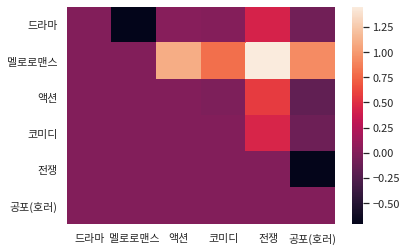

In [39]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font="Noto Sans CJK JP")

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name)
ax

In [40]:
len(matrix) # 구한 결과를 21x21 매트릭스 형태로 표현

6

## 프로젝트: 모든 장르간 편향성 측정해보기

### 형태소 분석기를 이용해, 품사가 명사인 경우 해당 단어를 추출하기
* 위 실습에서 만든 ```tokenized``` 사용

In [ ]:
with open('weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

In [ ]:
# 약 10분정도 걸립니다.
okt = Okt()
tokenized = []
with open('weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [ ]:
print(len(tokenized))

### 추출된 결과로 embedding model 만들기
* 위 실습에서 만든 ```w2v``` 사용

In [ ]:
# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. 
w2v = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  

w2v.most_similar(positive=['영화'])

### target, attribute 단어 셋 만들기
* 위 실습에서 만든 ```read_token()```, ```art```, ```gen```, ```target_art```, ```target_gen``` 사용

In [ ]:
art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open('weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [ ]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

In [ ]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

In [ ]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 spart matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 spart matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

In [ ]:
# 중복 단어 처리 후, TF-IDF 높은 상위 15개
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in w2v.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in w2v.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [ ]:
print(target_art)

In [ ]:
print(target_gen)

#### 장르별 대표 단어 추출

In [45]:
# genre_txt = ['synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_action.txt', 'synopsis_comedy.txt', 'synopsis_war.txt', 'synopsis_horror.txt']
genre_txt = list(filter(lambda x:x.startswith('synopsis_'), os.listdir('weat/')))
genre_txt.remove('synopsis_gen.txt')
genre_txt.remove('synopsis_art.txt') 

# genre_name = ['드라마', '멜로로맨스', '액션', '코미디', '전쟁', '공포(호러)']
genre_name = list(map(lambda x:x.split('_')[1].split('.txt')[0], genre_txt))

print('genre_txt:', genre_txt)
print('genre_name:', genre_name, '\n')

genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

genre_txt: ['synopsis_war.txt', 'synopsis_documentary.txt', 'synopsis_crime.txt', 'synopsis_fantasy.txt', 'synopsis_horror.txt', 'synopsis_comedy.txt', 'synopsis_drama.txt', 'synopsis_musical.txt', 'synopsis_mystery.txt', 'synopsis_animation.txt', 'synopsis_western.txt', 'synopsis_SF.txt', 'synopsis_adventure.txt', 'synopsis_show.txt', 'synopsis_family.txt', 'synopsis_thriller.txt', 'synopsis_etc.txt', 'synopsis_adult.txt', 'synopsis_action.txt', 'synopsis_romance.txt', 'synopsis_historical.txt']
genre_name: ['war', 'documentary', 'crime', 'fantasy', 'horror', 'comedy', 'drama', 'musical', 'mystery', 'animation', 'western', 'SF', 'adventure', 'show', 'family', 'thriller', 'etc', 'adult', 'action', 'romance', 'historical'] 

synopsis_war.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.


In [46]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [47]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in w2v:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

war: 전쟁, 독일군, 전투, 

/home/aiffel0042/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  del sys.path[0]


위해, 작전, 시작, 부대, 윈터스, 독일, 연합군, 미군, 임무, 자신, 사람, 나치, 
documentary: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
crime: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
fantasy: 자신, 그녀, 시작, 위해, 사람, 사랑, 요괴, 영화제, 이야기, 영화, 소녀, 남자, 인간, 세상, 세계, 
horror: 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
comedy: 그녀, 자신, 시작, 위해, 사랑, 사람, 친구, 영화, 남자, 여자, 영화제, 가족, 과연, 마을, 사건, 
drama: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
musical: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
mystery: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 아이, 
animation: 애니메이션, 국제, 영화제, 친구, 인디애니페스트, 위해, 자신, 시작, 사람, 페스티벌, 서울, 이야기, 아이, 마을, 소녀, 
western: 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
adventure: 위해, 자신, 시작, 친구, 마을, 아버지, 영화, 아이, 사람, 여행, 세계, 앤트, 세상, 가족, 모험, 
show: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 

### WEAT score 계산과 시각화

In [48]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [49]:
A = np.array([w2v.wv[word] for word in target_art])
B = np.array([w2v.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        X = np.array([w2v.wv[word] for word in attributes[i]])
        Y = np.array([w2v.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [50]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 1.1 or matrix[i][j] < -1.1:
            print(genre_name[i], genre_name[j],matrix[i][j])

war romance -1.4355603
documentary horror -1.1569412
documentary mystery -1.2667223
documentary thriller -1.1652426
documentary adult -1.2553222
documentary romance -1.4924939
crime romance -1.2534356
musical romance -1.103853
animation romance -1.18203
western romance -1.1579939
SF romance -1.3546846
etc romance -1.1878544


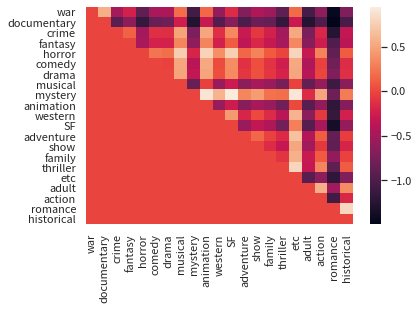

In [51]:
import numpy as np; 
import seaborn as sns; 

np.random.seed(0)

# 한글 지원 폰트
sns.set(font="Noto Sans CJK JP")

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name)
ax

In [52]:
len(matrix)

21